In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**8. In the lab, a classification tree was applied to the Carseats data set af-
ter converting Sales into a qualitative response variable. Now we will
seek to predict Sales using regression trees and related approaches,
treating the response as a quantitative variable.
(a) Split the data set into a training set and a test set.**

In [3]:
Carseats = pd.read_csv("data/Carseats.csv")
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Carseats, test_size = 0.2, random_state = 1)
columns = '1'
for column in Carseats.columns:
    columns = columns + '+' + column
y_test,X_test = patsy.dmatrices('Sales ~ {} - Sales'.format(columns), test_set, return_type = 'dataframe')
y_train,X_train = patsy.dmatrices('Sales ~ {} - Sales'.format(columns), train_set, return_type = 'dataframe')
X_train.drop('Intercept',axis = 1,inplace= True)
X_test.drop('Intercept',axis = 1,inplace= True)

**(b) Fit a regression tree to the training set. Plot the tree, and inter-
pret the results. What test MSE do you obtain?**

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
tree_reg = DecisionTreeRegressor(random_state = 1)
tree_reg.fit(X_train,y_train)
mean_squared_error(y_test,tree_reg.predict(X_test))

6.151969999999999

**(c) Use cross-validation in order to determine the optimal level of
tree complexity. Does pruning the tree improve the test MSE?**

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'min_impurity_decrease':np.linspace(0,0.5,1001)}
tree_reg = DecisionTreeRegressor(random_state = 1)
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'min_impurity_decrease': array([0.    , 0.0005, 0.001 , ..., 0.499 , 0.4995, 0.5   ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [7]:
grid_search.best_params_

{'min_impurity_decrease': 0.043000000000000003}

In [8]:
tree_reg = DecisionTreeRegressor(random_state = 1,min_impurity_decrease = grid_search.best_params_['min_impurity_decrease'])
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.043000000000000003,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='deprecated', random_state=1, splitter='best')

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


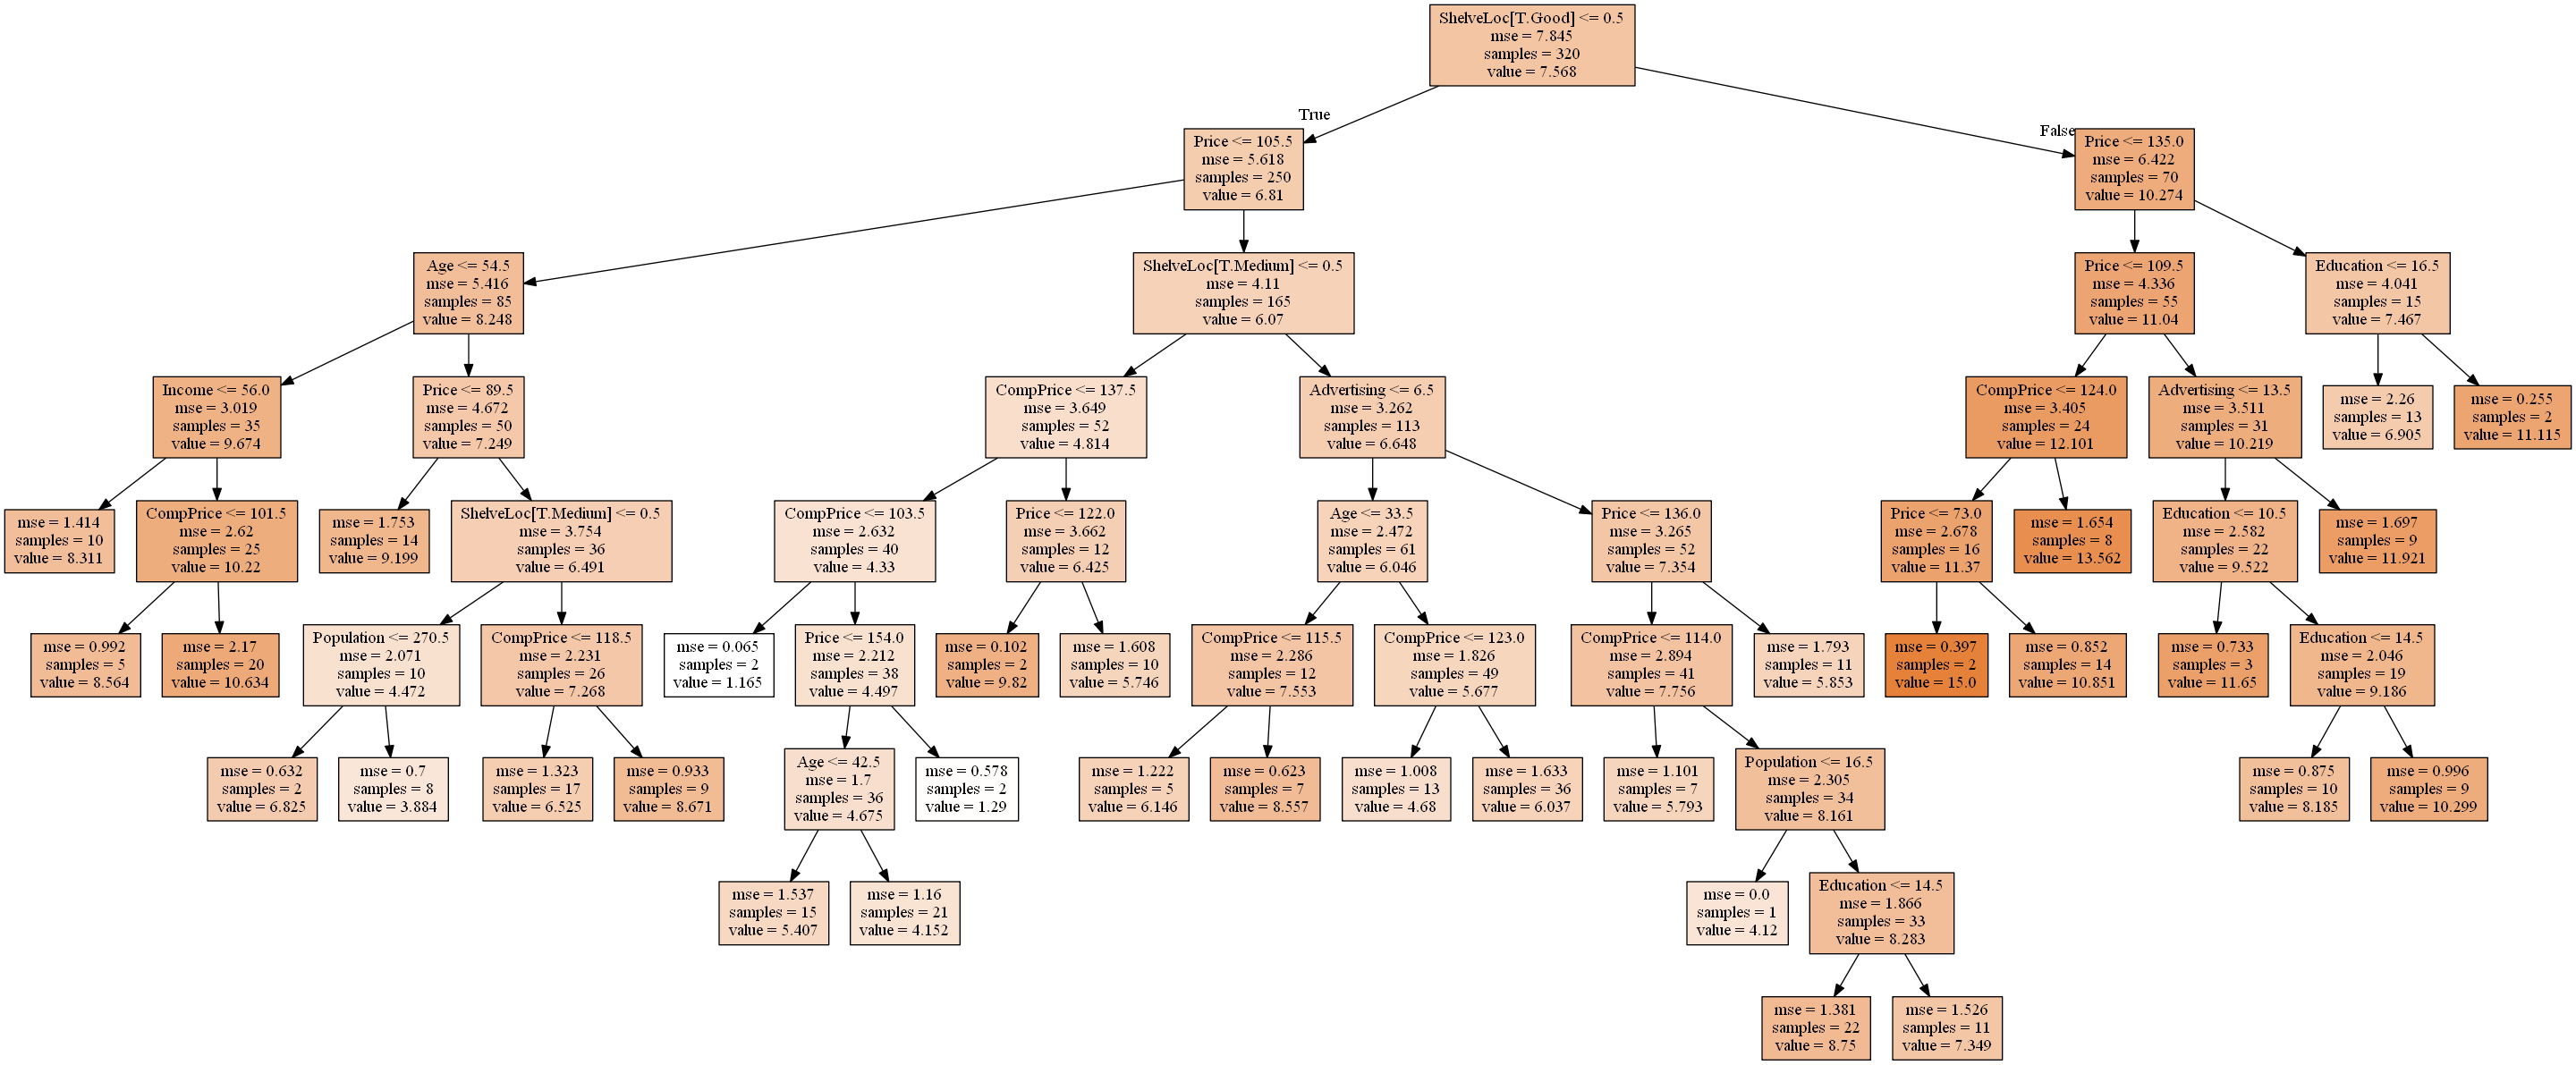

In [9]:
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydot
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)
graph1, = print_tree(tree_reg, features=X_train.columns, class_names=y_train.columns)
Image(graph1.create_png())

In [10]:
mean_squared_error(y_test,tree_reg.predict(X_test))

5.324495456871778

有一定改善但不明显


**(d) Use the bagging approach in order to analyze this data. What
test MSE do you obtain? Use the importance() function to de-
termine which variables are most important.**

In [11]:
from sklearn.ensemble import RandomForestRegressor
bag_rf_reg = RandomForestRegressor(n_estimators=300,random_state=1,max_features = len(X_train.columns))
bag_rf_reg.fit(X_train,y_train.values.ravel())
mean_squared_error(y_test,bag_rf_reg.predict(X_test))

3.2116043536527785

改善明显

In [12]:
feature_importance=pd.DataFrame({'feature':X_train.columns, 'importance':(bag_rf_reg.feature_importances_ * 100).round(3)})
feature_importance.sort_values('importance',ascending=False)

,feature,importance
8,Price,27.527
0,ShelveLoc[T.Good],26.452
4,CompPrice,9.619
9,Age,9.576
6,Advertising,7.162
1,ShelveLoc[T.Medium],6.635
5,Income,5.346
7,Population,4.053
10,Education,2.776
3,US[T.Yes],0.430


**(e) Use random forests to analyze this data. What test MSE do you
obtain? Use the importance() function to determine which vari-
ables are most important. Describe the effect of m, the number of
variables considered at each split, on the error rate
obtained.**

In [13]:
sqrt_rf_reg =  RandomForestRegressor(n_estimators=300,random_state=1,max_features = 'sqrt')
sqrt_rf_reg.fit(X_train,y_train.values.ravel())
mean_squared_error(y_test,sqrt_rf_reg.predict(X_test))

3.5057658484305563

sqrt略差于装袋法

In [14]:
feature_importance=pd.DataFrame({'feature':X_train.columns, 'importance':(sqrt_rf_reg.feature_importances_ * 100).round(3)})
feature_importance.sort_values('importance',ascending=False)

,feature,importance
8,Price,23.082
0,ShelveLoc[T.Good],19.969
9,Age,11.271
6,Advertising,9.955
4,CompPrice,9.430
5,Income,7.730
7,Population,7.241
10,Education,4.614
1,ShelveLoc[T.Medium],4.226
3,US[T.Yes],1.487


与装袋法接近，但是TOP3的重要突出性有所下降

In [15]:
divided_rf_reg = RandomForestRegressor(n_estimators=300,random_state=1,max_features = 0.5)
divided_rf_reg.fit(X_train,y_train.values.ravel())
mean_squared_error(y_test,divided_rf_reg.predict(X_test))

3.286582843111114

1/2随机森林在sqrt与装袋法之间

In [16]:
feature_importance=pd.DataFrame({'feature':X_train.columns, 'importance':(divided_rf_reg.feature_importances_ * 100).round(3)})
feature_importance.sort_values('importance',ascending=False)

,feature,importance
8,Price,24.775
0,ShelveLoc[T.Good],23.163
9,Age,10.702
6,Advertising,9.384
4,CompPrice,9.068
5,Income,6.358
7,Population,5.968
1,ShelveLoc[T.Medium],5.251
10,Education,3.704
3,US[T.Yes],1.010
